### Tutorial #3 :: EKF Attitude Estimation


## Preliminaries
As before, let's define a couple of functions to help us with our EKF estimation filter.


In [1]:
import numpy as np
import scipy.linalg

def ekfUpdate(fcn_state,x,P,fcn_meas,z,Q,R):
    x1,A = linearize(fcn_state, x)
    P = A*P*A.T + Q
    z1,H = linearize(fcn_meas, x1)
    P12 = P*H.T
    R = scipy.linalg.cholesky( H*P12 + R )
    U = P12*np.linalg.pinv(R)
    dz = (z-z1)
    x = x1 +  U * np.linalg.pinv(R.T)*dz
    P = P - U*U.T
    return (x, P)

def linearize(fcn, x):
    z = fcn(x)
    n = len(x)
    m = len(z)
    A = np.mat( np.zeros( (m,n) ) )
    h = n*np.spacing(1)
    for k in range(n):
        x1 = np.matrix(x, dtype='complex')
        x1[k] += h*1j
        A[:,k] = fcn(x1).imag / h
    return (z, A)

# when we expand quaternion multiplication
def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    y = w1 * y2 + y1 * w2 + z1 * x2 - x1 * z2
    z = w1 * z2 + z1 * w2 + x1 * y2 - y1 * x2
    return np.array([w, x, y, z])

# and to conjugate a quaternion
def q_conj(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# quaternion magnitude
def q_mag(q):
    w, x, y, z = q
    return np.sqrt( w*w + x*x + y*y + z*z )

This code will do all of the heavy lifting for us. Now we need to decide what we're trying to estimate (our state) along with how we will describe the dynamics of our system (`fcn_state`) and our observation function (`fcn_meas`).

Let's start with something practical--let's estimate the orientation of the sensor attached to the person walking around that we loaded and plotted in Tutorial [1]. A natural selection for the state $x$ is just the components of a single quaternion rotation vector---$w, x, y,$ and $z$. 

So we'll say $x = [qw, qx, qy, qz]$ is 3D rotation of the object with respect to the global frame. Let's start with designing our state (process) equation, `fcn_state`. Note that, in addition to the state, we must pass `delta_t` to the state function. This allows us to evolve the state dynamics with knowledge of the elapsed time. 

One great benefit of using quaternions is that we can very easily use body-frame rotations (provided by the gyroscope) to evolve the state using a quaternion rotation.  Interestingly, we've chosen here to use the gyroscope rotations as an input to the state equation, rather than a state variable. This decision can sometimes seem arbitrary, but in essence it's often best to use "measurements" as those that can be used to *correct* your state estimates--i.e. those that provide feedback terms--like range, position, or orientation.

In [2]:
def fcn_state(state, delta_t, pqr):
    qw  = state.item(0)
    qx  = state.item(1)
    qy  = state.item(2)
    qz  = state.item(3)
    p,q,r = pqr
    
    # predicted next quaternion based on rotation
    qNow = np.array([[qw],[qx],[qy],[qz]])
    qGyr = np.array([[0],[p],[q],[r]])
    qChng = (1.0/2.0)*q_mult( qNow, qGyr )
    qNext = qNow + delta_t*qChng
    
    # normalize new quaternion
    qNext = qNext / q_mag(qNext)
        
    # predicted next state
    s = np.matrix([
            [qNext.item(0)],
            [qNext.item(1)],
            [qNext.item(2)],
            [qNext.item(3)],
        ])

    return s

Next, let's define our observations as a function of our state. We have an accelerometer, a gryoscope, and a magnetometer at our disposal. We'll use the magnetometer and accelerometer to generate an estimate of the device's orientation in absolute (global, world, etc.) terms. Accelerometer will give us pitch (rotation about y) and roll (rotation about x) in the world frame, while the magnetometer will give us an absolute yaw (rotation about z) orientation. In other words, we will have direct measurements of our entire rotation quaternion using accelerometer and magnetometer.

In [3]:
def fcn_meas(state):
    qw  = state.item(0)
    qx  = state.item(1)
    qy  = state.item(2)
    qz  = state.item(3)
    
    # creating our predicted measurement matrix
    z = np.matrix([
            # Accel sensors converted to Euler, converted to quaternions
            [qw],
            [qx],
            [qy],
            [qz],
        ])
    
    return z

So we've related the next state to the current state and we've estimated the observations we should see at some time in the future based on the current state. Both of these will, in conjunction with our covariance matrices, attempt to drive the state etimate to something sensible.

Let's tie it all together now.

In [4]:
import numpy as np

# initialize state
state_init = np.matrix([
        # quaternion
        [1], [0], [0], [0]
    ])

# initial state uncertainties
init_cov_ang = 0.50
P_init = np.diag( [
        init_cov_ang, init_cov_ang, init_cov_ang, init_cov_ang
    ])

# process covariances
cov_ang = 2.0
Q = np.diag( [
        cov_ang, cov_ang, cov_ang, cov_ang
    ])

# measurement covariances
cov_meas_ang = 2.0
R = np.diag( [
        cov_meas_ang, cov_meas_ang, cov_meas_ang, cov_meas_ang
    ])


As in Tutorial [2], the process covariance dictates how much we expect our state variables to vary in a *valid* manner--e.g. how much we might reasonably expect the position to vary on a per-second basis. The measurement covariance dictates how much we can trust each measurement---the more variance, the less trustworthy. 

As in Tutorial [1], let's load and pre-process our dataset.

In [5]:
from scipy import signal

# Load inertial data
data_imu = np.array(np.loadtxt('../data/imudata.txt', skiprows=1))
tstamps = data_imu[:,2]
acc_xyz = data_imu[:,[3,4,5]]
gyr_xyz = data_imu[:,[6,7,8]]
mag_xyz = data_imu[:,[9,10,11]]

# Filter accel. to get gravity vector and linear accel.
b, a = signal.butter(N=4, Wn=2.0/(100.0/2), btype='lowpass', analog=False, output='ba')
grav_xyz = signal.filtfilt(b,a,acc_xyz, axis=0)
lin_xyz = acc_xyz - grav_xyz

# Load ground truth data
data_tru = np.array(np.loadtxt('../data/groundtruth.txt', skiprows=1))
tru_xyz = data_tru[:,[2,3,4]]/1000.0
tru_rot = data_tru[:,[5,6,7,8,9,10,11,12,13]]
yaw_tru = []
for idx in range(len(tru_rot)):
    r = tru_rot[idx,:]
    Rb2w = np.matrix([
            [r[0],r[1],r[2]],
            [r[3],r[4],r[5]],
            [r[6],r[7],r[8]],
        ])
    xyz = Rb2w*np.array([[1],[0],[0]])
    dx = xyz.item(0)
    dy = xyz.item(1)
    yaw_tru.append( np.arctan2(dy,dx) )

One more thing is needed, however. In our measurement equation, we've assumed we have a way to measure orientation directly. We need to actually provide this, given our gravity vectors (low-pass filtered accelerometer). This is pretty straight forward, using a little trigonometery.

In [6]:
quat_meas = np.array([]).reshape(0,4)
euler_meas = np.array([]).reshape(0,3)

for idx in range(acc_xyz.shape[0]):
    # grav vectors
    grav = grav_xyz[idx,:]
    gx, gy, gz = grav
    
    # accel vectors
    ax, ay, az = lin_xyz[idx,:]
    
    # mag vectorx
    mag = mag_xyz[idx,:]
    mx, my, mz = mag/np.linalg.norm(mag)
    
    # get roll & pitch
    pitch = np.arcsin( gx/np.linalg.norm(grav) )
    roll  = np.arcsin( -gy/(np.cos(pitch)*np.linalg.norm(grav)) )
    
    # get yaw using magnetometer
    #MX = mx*np.cos(pitch) + my*np.sin(roll)*np.sin(pitch) + mz*np.cos(roll)*np.sin(pitch)
    #MY = my*np.cos(roll) - mz*np.sin(roll)
    #yaw = np.arctan2( MY, MX )
    
    # Cheat: use groundtruth yaw for now, mag sensor is way too noisy
    yaw = yaw_tru[idx]
    
    # convert Euler to quaternion
    qw = np.cos(roll/2)*np.cos(pitch/2)*np.cos(yaw/2) + np.sin(roll/2)*np.sin(pitch/2)*np.sin(yaw/2)
    qx = np.sin(roll/2)*np.cos(pitch/2)*np.cos(yaw/2) - np.cos(roll/2)*np.sin(pitch/2)*np.sin(yaw/2)
    qy = np.cos(roll/2)*np.sin(pitch/2)*np.cos(yaw/2) + np.sin(roll/2)*np.cos(pitch/2)*np.sin(yaw/2)
    qz = np.cos(roll/2)*np.cos(pitch/2)*np.sin(yaw/2) - np.sin(roll/2)*np.sin(pitch/2)*np.cos(yaw/2)
    
    # append angles to arrays
    quat_meas = np.vstack( [quat_meas, [qw, qx, qy, qz]])
    euler_meas = np.vstack( [euler_meas, [roll, pitch, yaw]])

Let's visualize the rotations we just calculated to make sure they seem reasonable.  We'd expect to see the yaw go through a series of turns (visible if integrated) corresponding to the right angles in the path traversed by the user. The pitch and roll will likely have a series of spikes as the user takes steps.

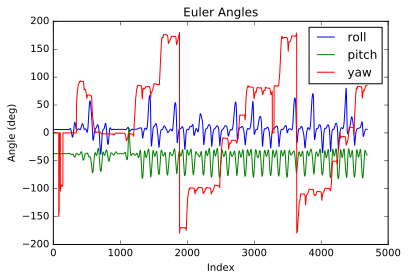

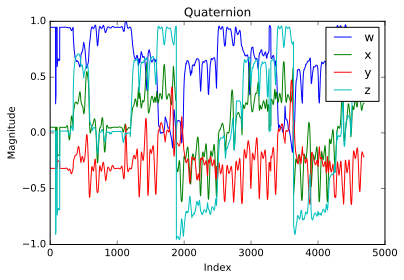

In [7]:
import matplotlib
import matplotlib.pyplot as plt

# First, some Jupyter plotting config
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

plt.plot( euler_meas*180.0/np.pi )  
plt.title('Euler Angles')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['roll', 'pitch', 'yaw'])
plt.show()

plt.plot( quat_meas )  
plt.title('Quaternion')
plt.xlabel('Index')
plt.ylabel('Magnitude')
plt.legend(['w','x','y','z'])
plt.show()

Looks good. Now all that is left is to loop over our sensor data and make calls to the EKF functions we defined earlier, which we'll do now.

In [8]:
# Some variables we'll need
KSTOP = 4000
state = state_init
P = P_init
time = 0
k = 0
t_last = tstamps[k]

# track our estimates, so we can plot them
quat_estimates = np.array([]).reshape(0,4)

for k in range(1,KSTOP):
    
    # gyro vector
    pqr = gyr_xyz[k,:]
    
    # quaternion vector
    qw, qx, qy, qz = quat_meas[k,:]
    
    # get measurement vector
    z = np.matrix([
            [qw],
            [qx],
            [qy],
            [qz],
        ])
        
    # time change
    dt = tstamps[k] - t_last
    t_last = tstamps[k]
    
    # forward propagation of state using rate gyros
    fcn_state_bound = lambda s: fcn_state(s, dt, pqr)
    
    # kalman filter update
    state, P = ekfUpdate(fcn_state_bound, state, P, fcn_meas, z, dt*Q, R)
    
    quat_estimates = np.vstack([quat_estimates, [state.item(0), state.item(1), state.item(2), state.item(3)]])
    
print('Measurement time elapsed:', np.round(t_last - tstamps[0],1), 'sec.')

('Measurement time elapsed:', 40.5, 'sec.')


And we're done! Let's plot the rotations from above so that we can see our final state estimates. We'll need to convert back to Euler angles so we can more easily interpret the angles.

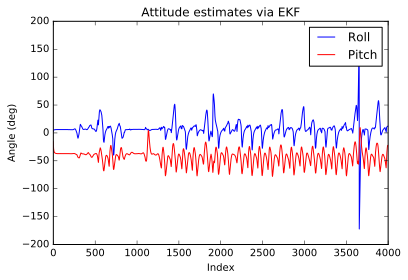

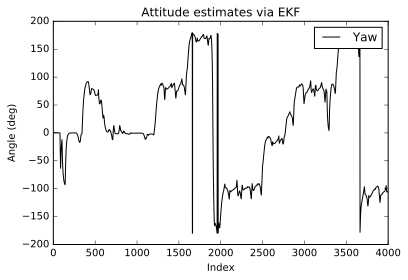

In [10]:
# convert quaternions to Euler for visualizing
q = quat_estimates
roll = np.arctan2( 2*(q[:,2]*q[:,3] + q[:,0]*q[:,1]), 1 - 2*(q[:,1]**2 + q[:,2]**2) )
pitch = -np.arcsin( 2*(q[:,1]*q[:,3] - q[:,0]*q[:,2]) )
yaw = np.arctan2( 2*(q[:,1]*q[:,2] + q[:,0]*q[:,3]), 1 - 2*(q[:,2]**2 + q[:,3]**2) )

# Plot pitch and roll
plt.plot(roll*180/np.pi, 'b-', markersize=3) 
plt.plot(pitch*180/np.pi, 'r-', markersize=3) 
plt.title('Attitude estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['Roll', 'Pitch'])
plt.show()

# Plot yaw
plt.plot(yaw*180/np.pi, 'k-', markersize=3) 
plt.title('Attitude estimates via EKF')
plt.xlabel('Index')
plt.ylabel('Angle (deg)')
plt.legend(['Yaw'])
plt.show()


Now this looks pretty similar to our initial "measurements" of the orientation. The only difference is there are some higher frequency components visible in the orientation, and that in fact is the desired difference--the gyroscope can accurately measure high frequency rotations in the short term, but it suffers from long term drifts. The accelerometer and magnetometer can be used for long term orientation estimates, but they cannot accurately track high rotation rates.